In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
ICT Capstone 2022 
Electricity Demand Forecasting with Machine Learning

@authors: 
Viriya Duch Sam
Su Hyun Kim
Kim Khanh Tran
Paola Abrogueña

PART 2: Data Preparation and Feature Engineering
Version 1.0.9 (Final)

Objective: 
- Identify requirements for data preparation
- Feature Engineering

"""

'\nICT Capstone 2022 \nElectricity Demand Forecasting with Machine Learning\n\n@authors: \nViriya Duch Sam\nSu Hyun Kim\nKim Khanh Tran\nPaola Abrogueña\n\nPART 2: Data Preparation and Feature Engineering\nVersion 1.0.9 (Final)\n\nObjective: \n- Identify requirements for data preparation\n- Feature Engineering\n\n'

In [5]:
import os

## Data manipulation
import numpy as np
import pandas as pd 
from datetime import datetime
from operator import itemgetter

## Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Seasonal Decompose
from statsmodels.tsa.seasonal import seasonal_decompose

## Autocorrelation Function
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [6]:
sns.set_style('darkgrid')

# Introduction
After initial EDA, we are now ready to proceed to final data preparation. In this stage, we will import our cleaned dataset to perform further preparation operations for a more refined dataset. 

In [15]:
# Import clean dataset
fname = "clean_data.csv"

df = pd.read_csv(fname)
df['date'] = pd.to_datetime(df['date'])

# Changing Boolean Variables to binary values
df['school_day'] = df['school_day'].replace([True, False], [1, 0]) 
df['holiday'] = df['holiday'].replace([True, False], [1, 0])

# Identify problems
In this stage, we will first manually eliminate features from our original data frame that we are not interested in exploring. Then we will design new features based on existing columns of our dataset. 

# Feature Engineering
In this stage, we will first manually eliminate features from our original data frame that we are not interested in exploring. Then we will design new features based on existing columns of our dataset. 

## Feature Elimination
For this project, we are only interested in total demand for each date data; thus, the following columns will be eliminated:
- RRP                    
- demand_pos_RRP         
- RRP_positive          
- demand_neg_RRP    
- RRP_negative         
- frac_at_neg_RRP

This is also for the sake of eliminating potentially confusing features from our model training, which might have an impact on the overall accuracy.

In [16]:
def dropCols(data, cols):
    data = data.drop(columns = cols)
    return data

In [17]:
cols = ['RRP', 'demand_pos_RRP', 'RRP_positive', 'demand_neg_RRP', 'RRP_negative', 'frac_at_neg_RRP']
df = dropCols(df, cols)
df = df.set_index('date').sort_index()

## Feature Design
Add new features : calendar features and lag features

### Design New Features from Calendar Data
- month (int: 1 to 2) 
- season (int: 1 to 4) 
- day_of_week (int: 1 to 7)  
- weekend (bool: 1 or 0) 
- pre_covid (bool: 1 or 0) 

In [19]:
def add_calendar_features(data):
    split_date = "2019-12-31" ## Pre-Covid
    
    data['month'] = data.index.month.astype(int)
    data['season'] = data['month'].apply(lambda month_number: (month_number % 12 + 3) // 3).astype(int) 
    data['day_of_week'] = (data.index.dayofweek+1).astype(int) ## Adding +1 to dow index to avoid 0th day 
    data['weekend'] = (data.index.dayofweek+1) > 5 ## Weekend 
    data['weekend'] = data.weekend.replace([True, False], [1, 0])
    data['pre_covid'] = data.index.date.astype(str) <= split_date
    data['pre_covid'] = data['pre_covid'].replace([True, False], [1, 0])
    
    cols = list(data.columns)
    X = data[cols]
    
    return X

In [21]:
df = add_calendar_features(df)
df.head()

,demand,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday,month,season,day_of_week,weekend,pre_covid
date,,,,,,,,,,,,
2015-01-01,99635.030,13.3,26.9,23.6,0.0,0,1,1,1,4,0,1
2015-01-02,129606.010,15.4,38.8,26.8,0.0,0,0,1,1,5,0,1
2015-01-03,142300.540,20.0,38.2,26.5,0.0,0,0,1,1,6,1,1
2015-01-04,104330.715,16.3,21.4,25.2,4.2,0,0,1,1,7,1,1
2015-01-05,118132.200,15.0,22.0,30.7,0.0,0,0,1,1,1,0,1


## Designing Lag Features

In order to determine optimal lag periods, we will first conduct an seasonal decompose exploration, then write an Autocorrelation Function for demand (our target value).

### Seasonal Decompose Exploration

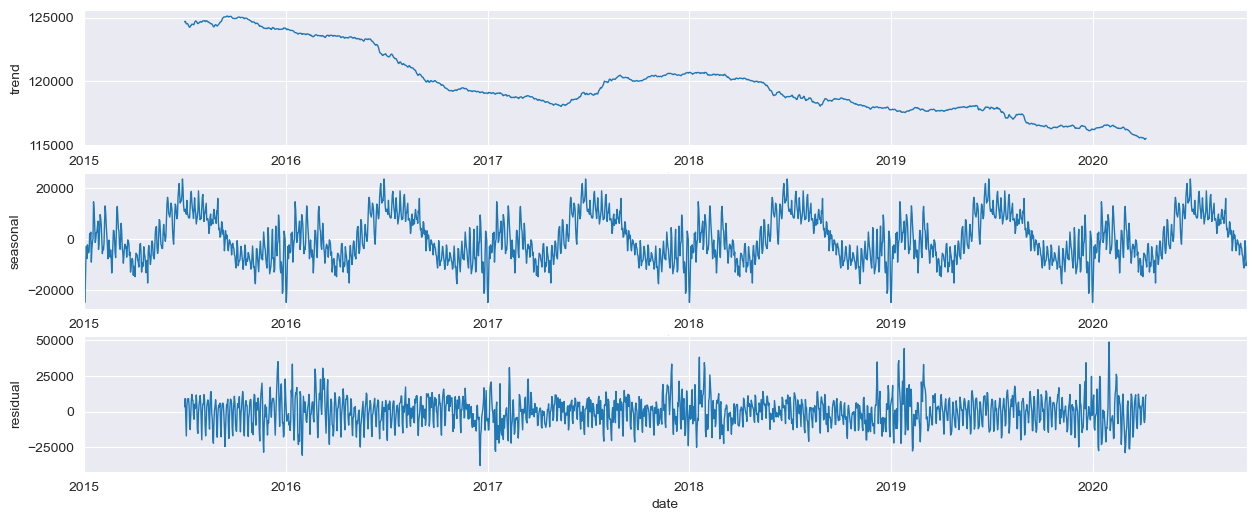

In [23]:
res = seasonal_decompose(df.demand, model = "additive", period = 365)

fig, ax = plt.subplots(3,1, figsize=(15,6))
res.trend.plot(ax=ax[0],ylabel = "trend", lw=1)
res.seasonal.plot(ax=ax[1],ylabel = "seasonal", lw=1)
res.resid.plot(ax=ax[2],ylabel = "residual", lw=1)
plt.show()

### Autocorrelation and Partial Autocorrelation

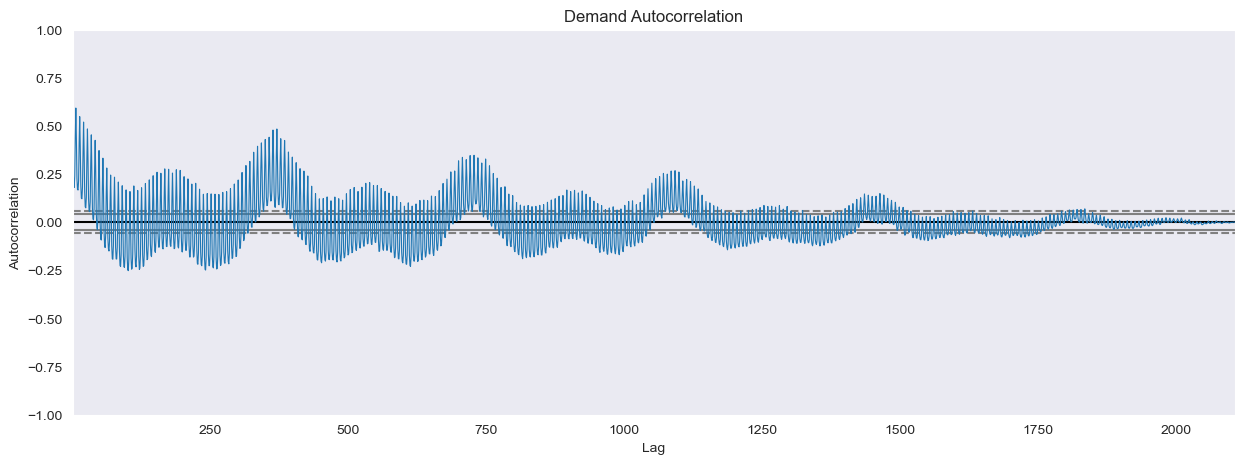

In [24]:
# Autocorrelation plot
plt.figure(figsize = (15, 5))
plt.title('Demand Autocorrelation')
_ = pd.plotting.autocorrelation_plot(df.demand, lw=0.8)

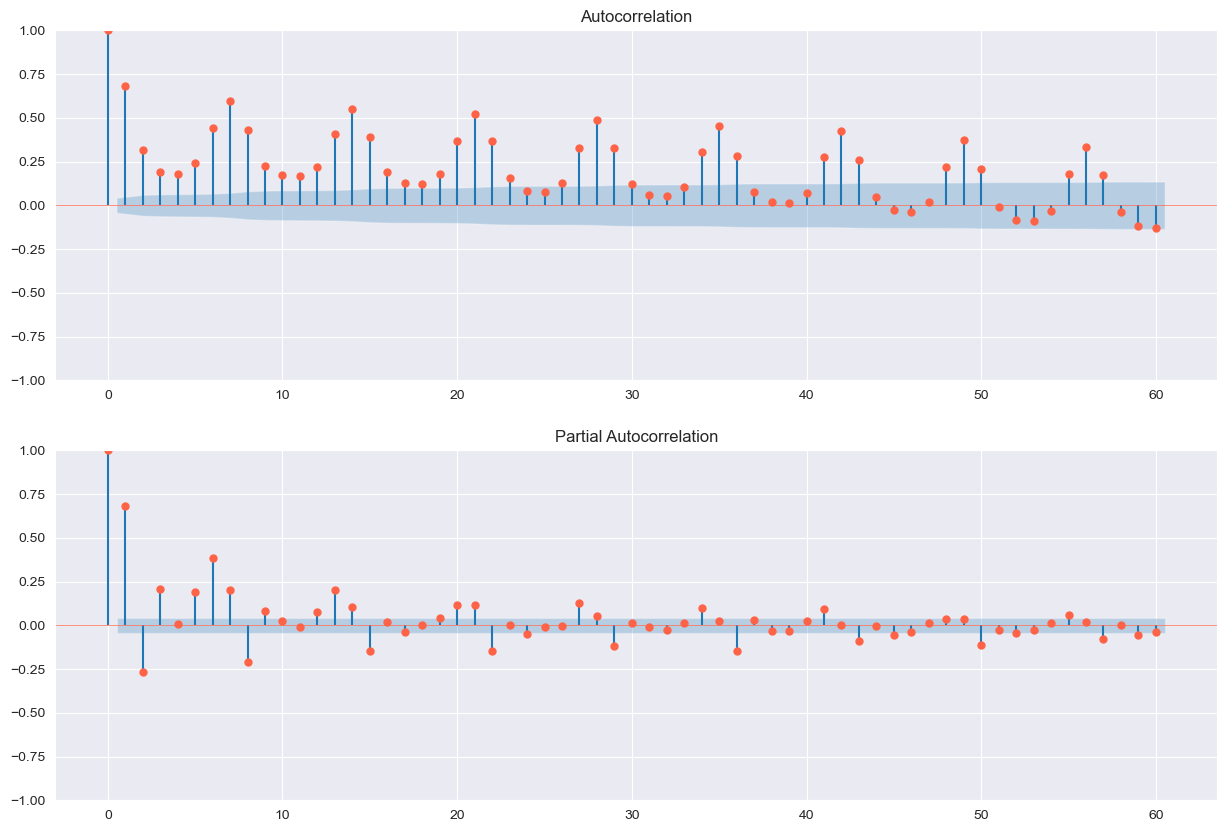

In [25]:
fig, ax = plt.subplots(2,1, figsize=(15, 10))
plot_acf(df.demand, ax=ax[0], lags = 60, lw=0.5, c='tomato')
plot_pacf(df.demand, ax=ax[1], lags = 60, lw=0.5, c='tomato', method='ywm')
plt.show()

In [26]:
# Calculate ACF values
lags = list(sm.tsa.acf(df.demand, nlags=30).astype(str))
lags_sorted = lags.copy()
lags_sorted.sort(reverse = True)

print("========== Highest Lag Scores =========\n")
for i in range(len(lags)):
    lagIndex = lags.index(lags_sorted[i])
    print(f'[{lagIndex}] :', lags_sorted[i])
    i += 1

========== Highest Lag Scores =========

[0] : 1.0
[1] : 0.678881029791747
[7] : 0.5932478955530955
[14] : 0.5485478328499128
[21] : 0.5202482898218062
[28] : 0.4845630652607733
[6] : 0.44050376703398453
[8] : 0.4301672228176428
[13] : 0.40593221356553416
[15] : 0.39166344067967884
[20] : 0.36796249432093525
[22] : 0.365783730237284
[29] : 0.3299311565207396
[27] : 0.32760016357077304
[2] : 0.31542807550694846
[5] : 0.24002231020079037
[9] : 0.22656585654492814
[12] : 0.21686910463065484
[3] : 0.19273176065971556
[16] : 0.19181416807006768
[4] : 0.18044024221142727
[19] : 0.18028647213668927
[10] : 0.17053165667102949
[11] : 0.16700385983492866
[23] : 0.15721242139706004
[26] : 0.12923201715479019
[17] : 0.12479077955952264
[30] : 0.12339453809079176
[18] : 0.12163589181116616
[24] : 0.0795392852548776
[25] : 0.07470555357949939


From these results, we determine that the optimal lag periods are 7, 14, 21, and 28. However, for the sake of conventional sectioning of a single month (say, 1-week, 2-weeks, or 4-weeks), we will use 7, 14, and 28 (instead of 21).

### Adding Lag Columns

In [27]:
def create_lag_features(df, label=None):
    df['demand_7_days_lag'] = df['demand'].shift(7).fillna(0)
    df['demand_14_days_lag'] = df['demand'].shift(14).fillna(0)
    df['demand_28_days_lag'] = df['demand'].shift(28).fillna(0)
    
    df['demand_7_days_mean'] = df['demand'].rolling(window = 7).mean().fillna(0)
    df['demand_14_days_mean'] = df['demand'].rolling(window = 14).mean().fillna(0)
    df['demand_28_days_mean'] = df['demand'].rolling(window = 28).mean().fillna(0)
    
    df['demand_7_days_std'] = df['demand'].rolling(window = 7).std().fillna(0)
    df['demand_14_days_std'] = df['demand'].rolling(window = 14).std().fillna(0)
    df['demand_28_days_std'] = df['demand'].rolling(window = 28).std().fillna(0)
    
    df['demand_7_days_max'] = df['demand'].rolling(window = 7).max().fillna(0)
    df['demand_14_days_max'] = df['demand'].rolling(window = 14).max().fillna(0)
    df['demand_28_days_max'] = df['demand'].rolling(window = 28).max().fillna(0)
    
    df['demand_7_days_min'] = df['demand'].rolling(window = 7).min().fillna(0)
    df['demand_14_days_min'] = df['demand'].rolling(window = 14).min().fillna(0)
    df['demand_28_days_min'] = df['demand'].rolling(window = 28).min().fillna(0)
    
    df['solar_exposure_7_lag'] = df["solar_exposure"].shift(7).fillna(0)
    df['solar_exposure_14_lag'] = df["solar_exposure"].shift(14).fillna(0)
    df['solar_exposure_28_lag'] = df["solar_exposure"].shift(28).fillna(0)
    
    df['solar_exposure_7_mean'] = df['solar_exposure'].rolling(window = 7).mean().fillna(0)
    df['solar_exposure_14_mean'] = df['solar_exposure'].rolling(window = 14).mean().fillna(0)
    df['solar_exposure_28_mean'] = df['solar_exposure'].rolling(window = 28).mean().fillna(0)
    
    df['solar_exposure_7_std'] = df['solar_exposure'].rolling(window = 7).std().fillna(0)
    df['solar_exposure_14_std'] = df['solar_exposure'].rolling(window = 14).std().fillna(0)
    df['solar_exposure_28_std'] = df['solar_exposure'].rolling(window = 28).std().fillna(0)
    
    df['solar_exposure_7_min'] = df['solar_exposure'].rolling(window = 7).min().fillna(0)
    df['solar_exposure_14_min'] = df['solar_exposure'].rolling(window = 14).min().fillna(0)
    df['solar_exposure_28_min'] = df['solar_exposure'].rolling(window = 28).min().fillna(0)
    
    df['solar_exposure_7_max'] = df['solar_exposure'].rolling(window = 7).max().fillna(0)
    df['solar_exposure_28_max'] = df['solar_exposure'].rolling(window = 28).max().fillna(0)
    df['solar_exposure_14_max'] = df['solar_exposure'].rolling(window = 14).max().fillna(0)
    
    df['rainfall_7_lag'] = df["rainfall"].shift(7).fillna(0)
    df['rainfall_14_lag'] = df["rainfall"].shift(14).fillna(0)
    df['rainfall_28_lag'] = df["rainfall"].shift(28).fillna(0)
    
    df['rainfall_7_mean'] = df['rainfall'].rolling(window = 7).mean().fillna(0)
    df['rainfall_14_mean'] = df['rainfall'].rolling(window = 14).mean().fillna(0)
    df['rainfall_28_mean'] = df['rainfall'].rolling(window = 28).mean().fillna(0)
    
    df['rainfall_7_std'] = df['rainfall'].rolling(window = 7).std().fillna(0)
    df['rainfall_14_std'] = df['rainfall'].rolling(window = 14).std().fillna(0)
    df['rainfall_28_std'] = df['rainfall'].rolling(window = 28).std().fillna(0)
    
    df['rainfall_7_min'] = df['rainfall'].rolling(window = 7).min().fillna(0)
    df['rainfall_14_min'] = df['rainfall'].rolling(window = 14).min().fillna(0)
    df['rainfall_28_min'] = df['rainfall'].rolling(window = 28).min().fillna(0)
    
    df['rainfall_7_max'] = df['rainfall'].rolling(window = 7).max().fillna(0)
    df['rainfall_14_max'] = df['rainfall'].rolling(window = 14).max().fillna(0)
    df['rainfall_28_max'] = df['rainfall'].rolling(window = 28).max().fillna(0)
    
    cols = list(df.columns)
    
    for lag in ('7', '14', '28'):
        for col in ('lag', 'mean', 'std', 'max', 'min'):
            cols.append(f'demand_{lag}_days_{col}')
            cols.append(f'solar_exposure_{lag}_{col}')
            cols.append(f'rainfall_{lag}_{col}')
    
    X = df[cols]
    
    if label:
        y = df[label]
        return X, y
    
    return X

In [28]:
create_lag_features(df, label='demand')

(                demand  min_temperature  max_temperature  solar_exposure  \
 date                                                                       
 2015-01-01   99635.030             13.3             26.9            23.6   
 2015-01-02  129606.010             15.4             38.8            26.8   
 2015-01-03  142300.540             20.0             38.2            26.5   
 2015-01-04  104330.715             16.3             21.4            25.2   
 2015-01-05  118132.200             15.0             22.0            30.7   
 ...                ...              ...              ...             ...   
 2020-10-02   99585.835             12.8             26.0            22.0   
 2020-10-03   92277.025             17.4             29.4            19.8   
 2020-10-04   94081.565             13.5             29.5             8.4   
 2020-10-05  113610.030              9.1             12.7             7.3   
 2020-10-06  122607.560              8.9             12.6             5.8   

In [29]:
# Check new df shape
df.shape

(2106, 57)

In [30]:
# Export clean data frame to new csv file for next tasks
df.to_csv('engineered_data.csv')